In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import TensorDataset, DataLoader

### Task 1 - Preparación del conjunto de datos

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Task 2 - Arquitectura modelo

In [4]:
class IrisNet(nn.Module):
    def __init__(self, input_dim=4, hidden_sizes=(16, 8), output_dim=3, dropout=0.0, use_batchnorm=False):
        super().__init__()
        layers = []
        prev = input_dim

        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if dropout > 0.0:
                layers.append(nn.Dropout(p=dropout))
            prev = h

        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

### Task 3 - Funciones de pérdida

In [5]:
def to_onehot(y, num_classes=3): # Etiquetas a one-hot
    return np.eye(num_classes)[y]

In [6]:
def train_model(loss_name="crossentropy", epochs=100, lr=0.01, batch_size=16):
    # Convertir a tensores
    X_tr = torch.tensor(X_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.long)
    X_va = torch.tensor(X_val, dtype=torch.float32)
    y_va = torch.tensor(y_val, dtype=torch.long)

    # Dataset y DataLoader
    train_ds = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Modelo y optimizador
    model = IrisNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Función de pérdida
    if loss_name == "crossentropy":
        criterion = nn.CrossEntropyLoss()
    elif loss_name == "mse":
        criterion = nn.MSELoss()
        y_tr_onehot = torch.tensor(to_onehot(y_train), dtype=torch.float32)
        y_va_onehot = torch.tensor(to_onehot(y_val), dtype=torch.float32)
    elif loss_name == "nll":
        model.net.add_module("logsoftmax", nn.LogSoftmax(dim=1))
        criterion = nn.NLLLoss()
    else:
        raise ValueError("Función de pérdida no válida")

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            if loss_name == "mse":
                yb_oh = torch.tensor(to_onehot(yb.numpy()), dtype=torch.float32)
                loss = criterion(preds, yb_oh)
            else:
                loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        # Validación
        model.eval()
        with torch.no_grad():
            val_preds = model(X_va)
            if loss_name == "mse":
                val_loss = criterion(val_preds, y_va_onehot)
                predicted = val_preds.argmax(dim=1)
            else:
                val_loss = criterion(val_preds, y_va)
                predicted = val_preds.argmax(dim=1)
        val_losses.append(val_loss.item())

        # Validación final con accuracy
        with torch.no_grad():
            val_preds = model(X_va)
            predicted_classes = val_preds.argmax(dim=1)
            accuracy = (predicted_classes == y_va).float().mean().item()

    return train_losses, val_losses, accuracy

In [7]:
results = {}

for loss_name in ["crossentropy", "mse", "nll"]:
    print(f"Entrenando con {loss_name}...")
    train_l, val_l, acc = train_model(loss_name=loss_name)
    results[loss_name] = {
        "train_loss": train_l,
        "val_loss": val_l,
        "final_train_loss": train_l[-1],
        "final_val_loss": val_l[-1],
        "val_accuracy": acc
    }

Entrenando con crossentropy...
Entrenando con mse...
Entrenando con nll...


In [8]:
print("\nResumen de resultados:")
for name, stats in results.items():
    print(f"\nFunción de pérdida: {name}")
    print(f"  - Pérdida final (entrenamiento): {stats['final_train_loss']:.4f}")
    print(f"  - Pérdida final (validación):   {stats['final_val_loss']:.4f}")
    print(f"  - Accuracy validación final:    {stats['val_accuracy']*100:.2f}%")


Resumen de resultados:

Función de pérdida: crossentropy
  - Pérdida final (entrenamiento): 0.0898
  - Pérdida final (validación):   0.0501
  - Accuracy validación final:    100.00%

Función de pérdida: mse
  - Pérdida final (entrenamiento): 0.0172
  - Pérdida final (validación):   0.0348
  - Accuracy validación final:    93.33%

Función de pérdida: nll
  - Pérdida final (entrenamiento): 0.0881
  - Pérdida final (validación):   0.0434
  - Accuracy validación final:    100.00%


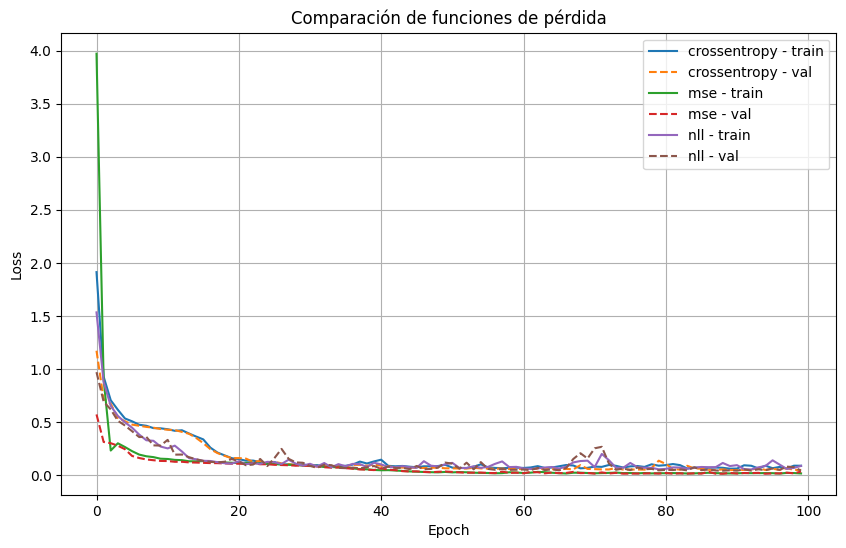

In [9]:
plt.figure(figsize=(10,6))
for name, stats in results.items():
    plt.plot(stats["train_loss"], label=f"{name} - train")
    plt.plot(stats["val_loss"], linestyle="--", label=f"{name} - val")
plt.title("Comparación de funciones de pérdida")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

### Task 4 - Técnicas de Regularización

In [10]:
def train_model(loss_name="crossentropy", epochs=100, lr=0.01, batch_size=16,
                use_dropout=False, weight_decay=0.0, use_l1=False):
    # Convertir a tensores
    X_tr = torch.tensor(X_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.long)
    X_va = torch.tensor(X_val, dtype=torch.float32)
    y_va = torch.tensor(y_val, dtype=torch.long)

    # Dataset y DataLoader
    train_ds = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Modelo y optimizador
    model = IrisNet(dropout=0.2 if use_dropout else 0.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Función de pérdida
    if loss_name == "crossentropy":
        criterion = nn.CrossEntropyLoss()
    elif loss_name == "mse":
        criterion = nn.MSELoss()
        y_train_oh = torch.tensor(to_onehot(y_train), dtype=torch.float32)
        y_val_oh = torch.tensor(to_onehot(y_val), dtype=torch.float32)
    elif loss_name == "nll":
        model.net.add_module("logsoftmax", nn.LogSoftmax(dim=1))
        criterion = nn.NLLLoss()
    else:
        raise ValueError("Función de pérdida no válida")

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)

            # Calcular pérdida
            if loss_name == "mse":
                yb_oh = y_train_oh[yb]
                loss = criterion(preds, yb_oh)
            else:
                loss = criterion(preds, yb)

            # L1 regularization
            if use_l1:
                l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters())
                loss += 1e-4 * l1_penalty

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        # Validación
        model.eval()
        with torch.no_grad():
            val_preds = model(X_va)
            if loss_name == "mse":
                val_loss = criterion(val_preds, y_val_oh)
            else:
                val_loss = criterion(val_preds, y_va)
        val_losses.append(val_loss.item())

    # Accuracy final
    with torch.no_grad():
        predicted_classes = val_preds.argmax(dim=1)
        accuracy = (predicted_classes == y_va).float().mean().item()

    return train_losses, val_losses, accuracy

In [11]:
experiments = {
    "baseline": dict(use_dropout=False, weight_decay=0.0, use_l1=False),
    "dropout":  dict(use_dropout=True,  weight_decay=0.0, use_l1=False),
    "l2":       dict(use_dropout=False, weight_decay=1e-3, use_l1=False),
    "l1":       dict(use_dropout=False, weight_decay=0.0, use_l1=True),
}

In [12]:
results_reg = {}
for name, config in experiments.items():
    print(f"Entrenando con {name}...")
    train_l, val_l, acc = train_model(
        loss_name="crossentropy",
        use_dropout=config["use_dropout"],
        weight_decay=config["weight_decay"],
        use_l1=config["use_l1"]
    )
    results_reg[name] = {
        "train_loss": train_l,
        "val_loss": val_l,
        "final_train_loss": train_l[-1],
        "final_val_loss": val_l[-1],
        "val_accuracy": acc
    }

Entrenando con baseline...
Entrenando con dropout...
Entrenando con l2...
Entrenando con l1...


In [13]:
print("\nResumen de regularización:")
for name, stats in results_reg.items():
    print(f"\nConfiguración: {name}")
    print(f"  - Pérdida final (train): {stats['final_train_loss']:.4f}")
    print(f"  - Pérdida final (val):   {stats['final_val_loss']:.4f}")
    print(f"  - Accuracy validación:   {stats['val_accuracy']*100:.2f}%")


Resumen de regularización:

Configuración: baseline
  - Pérdida final (train): 0.1321
  - Pérdida final (val):   0.0443
  - Accuracy validación:   100.00%

Configuración: dropout
  - Pérdida final (train): 0.3410
  - Pérdida final (val):   0.0640
  - Accuracy validación:   100.00%

Configuración: l2
  - Pérdida final (train): 0.1788
  - Pérdida final (val):   0.0589
  - Accuracy validación:   100.00%

Configuración: l1
  - Pérdida final (train): 0.0612
  - Pérdida final (val):   0.0536
  - Accuracy validación:   96.67%


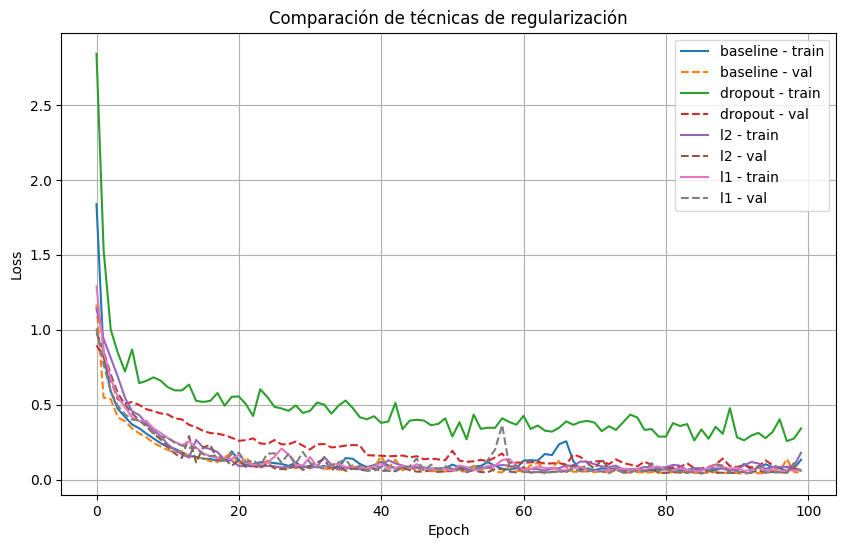

In [14]:
plt.figure(figsize=(10,6))
for name, stats in results_reg.items():
    plt.plot(stats["train_loss"], label=f"{name} - train")
    plt.plot(stats["val_loss"], linestyle="--", label=f"{name} - val")
plt.title("Comparación de técnicas de regularización")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()